# Face Recognition Project

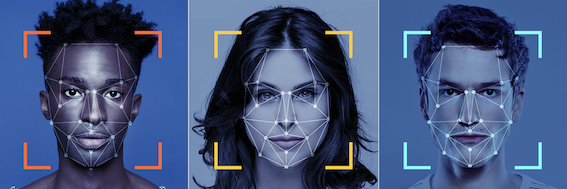

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

This basic notebook will give you 8/10 points, if completed fully. There are also additional features you might implement to get additional points. You may do additional tasks and receive additional points even if you didn't fully complete the basic notebook. This means you can choose which tasks to do. **Additional features that you might implement are listed in Telegram chat**.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

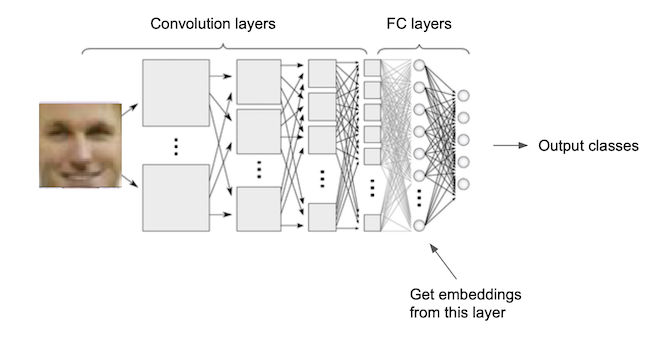

## Task 1 (2 points): build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [ ]:
! pip install wldhx.yadisk-direct
! curl -La $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip

Let's look at the data first:

In [2]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [2]:
import os
import cv2
import numpy as np
import math
from numpy.linalg import norm
import pandas as pd
from PIL import Image
from skimage import io, transform
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
import gc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

import torch
from torch import nn
from torchvision import models, transforms
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AdamW

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

Let's visualize some images to understand what we're dealing with:

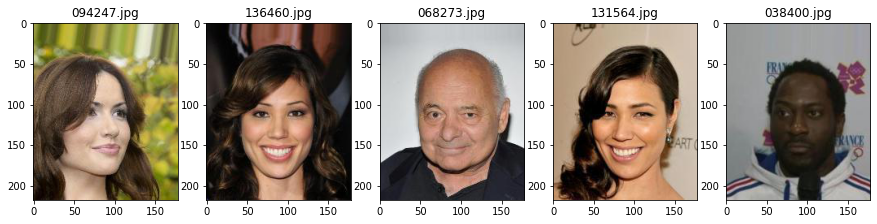

In [4]:
def show_imgs(directiry, images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join(directiry, img))
        imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

directiry = './celebA_train_500/celebA_imgs/'
images_names = os.listdir(directiry)[:5]
show_imgs(directiry, images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [5]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        if self.aug:
            image = self.aug(image)
        
        sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample['image'], sample['label']

In [6]:
normalize = [((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

transform  = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(280),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(*normalize[0]),
])
aug = transforms.Compose([
                transforms.ColorJitter(),
                transforms.RandomHorizontalFlip()
])

In [7]:
train_data = celebADataset('train', transform, aug)
val_data = celebADataset('val',transform)
test_data = celebADataset('test', transform)

In [8]:
# choose your own batch_size
batch_size = 25
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
def imshow(inp, norm, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([*norm[0]])
    std = np.array([*norm[-1]])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    
    try: 
        if title is not None:
            plt_ax.set_title(title)
    except:
        plt.title(title)
    plt_ax.grid(False)

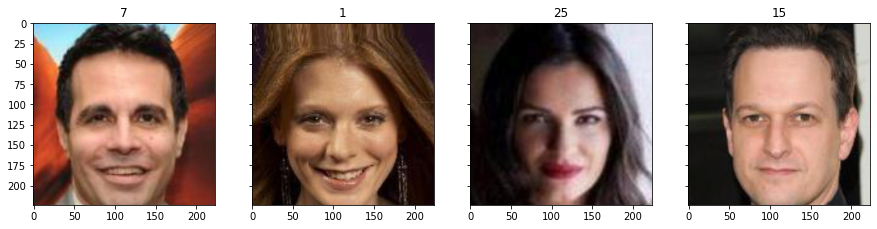

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(15, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_train, label =  train_data[random_characters]
    imshow(im_train, normalize[0], title=label, plt_ax=fig_x)

In [11]:
n_classes = len(np.unique(train_data.labels))

**Workflow**: train a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use whatever model you want, including pre-trained on ImageNet models from torchvision. Please note, that **it is not allowed to use pre-trained models on any other dataset except ImageNet**. 

To get higher score, try to adjust hyperparameters, maybe try augmentations, etc. 

Hints: Do not use too big model. Small ResNet-like network is enough to get the required score. Use at least 2 linear layers on the bottom. You'll need to drop the last layer after training and get image embeddings from the pre-last layer. It's not required to get the embedding from linear layer though: you may get it from last convolution layer, if you want.

**To get the whole mark for this section you need to achieve 70% accuracy on test set**.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(True) 

resnet.fc = nn.Sequential(
                    nn.Linear(resnet.fc.in_features, n_classes),
                    nn.BatchNorm1d(n_classes),
                    nn.ReLU(inplace=True),
                    nn.Linear(n_classes, n_classes),
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
model = resnet.to(device)

In [15]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=24)
criterion = nn.CrossEntropyLoss() 
loaders = {'train': train_loader, 'valid': val_loader}

In [16]:
def show_result(data, best_score):
    plt.figure(figsize=(22, 7))
        
    plt.subplot(1, 2, 1)
    sns.lineplot(data=data, x='epoch', y='train_loss', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_loss', color = 'cornflowerblue')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'])
    plt.title('Loss values')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=data, x='epoch', y='train_accuracy', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_accuracy', color = 'cornflowerblue')
    sns.lineplot(data=data, x='epoch', y=0.7, style=True, dashes=[(3,3)], color = 'tan')
    mask = np.array(data['valid_accuracy'])==best_score
    plt.scatter(np.array(data['epoch'])[mask], np.array(data['valid_accuracy'])[mask], color='salmon', s=40, marker='^')
    plt.ylabel('score')
    plt.legend(['train_accuracy', 'valid_accuracy', 'threshold'])
    plt.title('Score: accuracy')
        
    plt.show()   

In [17]:
def train(model, optimizer, scheduler, loss_fn, epochs, loaders, file_name, mode_fc=None):
    best_score = 0
    for epoch in range(epochs):
        result['epoch'].append(epoch+1)
        for mode, dataloader in tqdm(loaders.items()):
            running_loss, running_corrects, processed_data, valid_loss = 0,0,0,0
            
            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device, dtype=torch.long)

                if mode =='train':
                    model.train()
                    optimizer.zero_grad() 
                    if mode_fc=='yes':
                        Y_pred = model(X_batch, Y_batch)    
                    else: 
                        Y_pred = model(X_batch)
                else: 
                    model.eval()  
                    with torch.no_grad(): 
                        if mode_fc=='yes':
                              Y_pred = model(X_batch, Y_batch) 
                        else: 
                              Y_pred = model(X_batch)
                
                loss = loss_fn(Y_pred, Y_batch)
                preds = torch.argmax(Y_pred, 1)
                running_loss += loss.item() * X_batch.size(0)
                running_corrects += torch.sum(preds == Y_batch.data)
                processed_data += X_batch.size(0)
                
                if mode =='train':
                    loss.backward()
                    optimizer.step()
            
            loss_score = running_loss/processed_data
            accuracy = running_corrects.cpu().numpy()/processed_data
            result[str(mode)+'_loss'].append(loss_score)
            result[str(mode)+'_accuracy'].append(accuracy)
            
            if mode =='valid':
                if accuracy > best_score:
                    best_score = accuracy
                    torch.save(model.state_dict(), f'saved_weights_{file_name}.pt')   
                valid_loss = loss_score
            lr = optimizer.param_groups[0]['lr']
            scheduler.step(valid_loss)
            
        clear_output(wait=True)
        print(f'epoch training: {epoch+1}, lr optimizer: {lr}, loss value validate:{valid_loss:10.4f}, accuracy validate:{accuracy:10.4f}') #
        print()

        show_result(result, best_score)

epoch training: 20, lr optimizer: 1e-05, loss value validate:    0.8771, accuracy validate:    0.8312



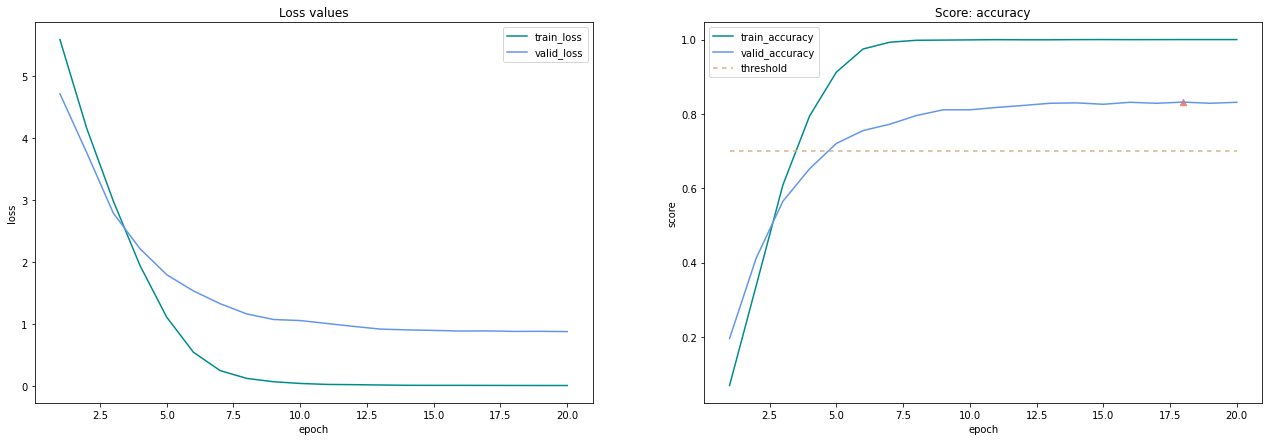

In [18]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_accuracy':[],'valid_accuracy':[]
}
epochs = 20
train(model, optimizer, scheduler, criterion, epochs, loaders, 'resnet50_sm')

Code for model evaluating (you can modify it if you want):

In [19]:
def evaluate(model, dataloader, loss_fn, mode_fc=None):
    
    losses = []
    running_corrects = 0
    processed_data = 0 

    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device, dtype=torch.long)
        
        with torch.no_grad():
            model.eval()
            if mode_fc=='yes':
                Y_pred = model(X_batch, Y_batch)
            else: 
                Y_pred = model(X_batch)
            
            loss = loss_fn(Y_pred, Y_batch)
            losses.append(loss.item())
    
            preds = torch.argmax(Y_pred, 1)
            running_corrects += torch.sum(preds == Y_batch.data)
            processed_data += X_batch.size(0)
        
    accuracy = running_corrects.cpu().numpy()/processed_data      
    return accuracy, np.mean(losses)

In [20]:
def get_embeddings(model, loader, fc = None):
    modules = list(model.children())[:-1]
    models_emb = nn.Sequential(*modules)
    labels_list, emb_list = [],[]
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device, dtype=torch.long)
        with torch.no_grad():
            models_emb.eval()
            emb = models_emb(X_batch)
            emb = emb/emb.norm(p=2, dim=1)[:, None]
            if fc is None:
                emb_list.extend(emb.view(X_batch.size()[0], -1).cpu().detach().numpy())
            else:
                emb_list.extend(emb.cpu().detach().numpy())
            labels_list.extend(Y_batch.cpu().numpy())
    return np.array(labels_list), np.array(emb_list)

In [21]:
test_accuracy, test_loss = evaluate(model, test_loader, criterion)
print(f'test loss:{test_loss:10.4f}, test accuracy:{test_accuracy:10.4f}')

labels_list_sm, emb_list_sm = get_embeddings(model, test_loader)
df_default = pd.DataFrame(result)[['epoch', 'valid_accuracy']]

test loss:    0.9492, test accuracy:    0.8112


На предобученной модели Resnet50 с двумя линейными слоями мы получили accuracy, который на тесте колеблется от 0,81 до 0,83, что является выше минимального допустимого порога. CrossEntropyLoss на тесте составили около 0,5.

**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

Рассчитаем косинусное сходство для выборки из 1000 фотографий из трейна и 1000 фотографий из теста

In [22]:
n_images = 1000

modules = list(model.children())[:-1] 
models_emb = nn.Sequential(*modules)

embedings = {
    'train_images':[],
    'train_emb_images':[],
    'train_labels':[],
    'test_images':[],
    'test_emb_images':[],
    'test_labels':[]
}

train_loader_one_image = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader_one_image = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

loaders = {'train':train_loader_one_image, 'test': test_loader_one_image}

In [23]:
for mode, loader in loaders.items():
    len_cumulative = 0
    for X_batch, Y_batch in loader:
        if len_cumulative<n_images:
            with torch.no_grad():
                models_emb.eval()
                emb = models_emb(X_batch.to(device)).flatten().cpu().numpy()
            embedings[str(mode)+'_images'].append(X_batch)
            embedings[str(mode)+'_emb_images'].append(emb)
            embedings[str(mode)+'_labels'].append(Y_batch.numpy())
     
        len_cumulative+=len(X_batch)

Посмотрим Cosine Similarity для двух рандомных классов

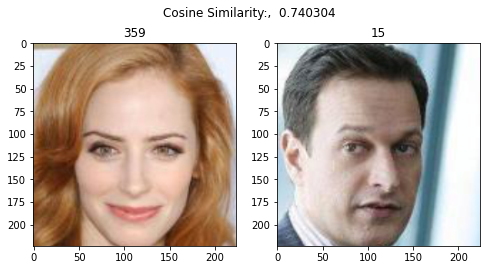

In [24]:
random = np.random.randint(0, n_images, 2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
imshow(embedings['train_images'][random[0]][0], normalize[0], title=embedings['train_labels'][random[0]][0])
plt.subplot(1, 2, 2)
imshow(embedings['test_images'][random[1]][0], normalize[0], title=embedings['test_labels'][random[1]][0])

train_emb, test_emb = embedings['train_emb_images'][random[0]], embedings['test_emb_images'][random[1]]
cosine = np.dot(train_emb, test_emb)/(norm(train_emb)*norm(test_emb))

plt.suptitle(f'Cosine Similarity:,  %f' % (cosine))
plt.show()

Посмотрим Cosine Similarity для рандомного класса 

In [33]:
index_test=[]
while len(index_test)==0:
    random_character = np.random.randint(0, n_images, 1)[0]

    index_train = np.where(embedings['train_labels']==random_character)[0]
    index_test = np.where(embedings['test_labels']==random_character)[0]
    
    index_not_this_character = np.where(embedings['train_labels']!=random_character)[0]

print(len(index_train),len(index_test))

1 4


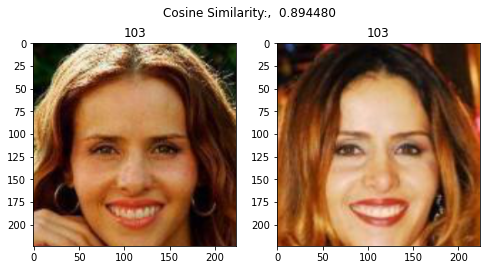

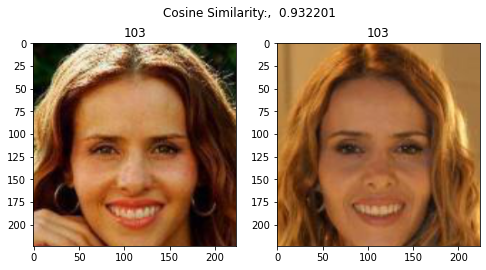

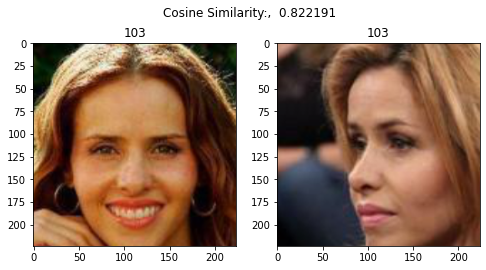

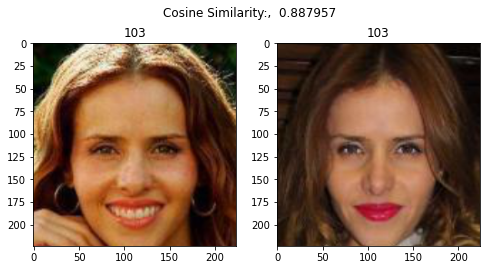

In [34]:
for i, y in enumerate(index_train): 
    for ii, yy in enumerate(index_test):
        plt.figure(figsize=(8, 4))
        index_tr, index_ts=index_train[i],index_test[ii]

        plt.subplot(1, 2, 1)
        imshow(embedings['train_images'][y][0], normalize[0], title=embedings['train_labels'][y][0])
        plt.subplot(1, 2, 2)
        imshow(embedings['test_images'][yy][0], normalize[0], title=embedings['test_labels'][yy][0])

        train_emb, test_emb = embedings['train_emb_images'][y], embedings['test_emb_images'][yy]
        cosine = np.dot(train_emb, test_emb)/(norm(train_emb)*norm(test_emb))
        
        plt.suptitle(f'Cosine Similarity:,  %f' % (cosine))
        plt.show()
    

Посмотрим дополнительно максимумы и минимумы для пар разных классов.

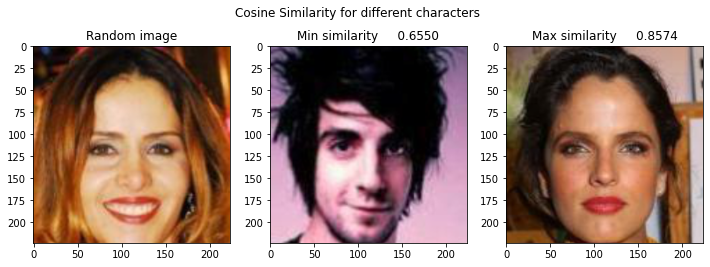

In [35]:
index_min, index_max = 0,0
cosine_min, cosine_max = 999,-999
test_emb = embedings['test_emb_images'][index_test[0]]
for i in index_not_this_character:
    train_emb = embedings['train_emb_images'][i]
    cosine = np.dot(train_emb, test_emb)/(norm(train_emb)*norm(test_emb))
    if cosine>cosine_max:
        index_max=i
        cosine_max = cosine
    elif cosine<cosine_min:
        index_min=i
        cosine_min = cosine

        
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
imshow(embedings['test_images'][index_test[0]][0], normalize[0], title='Random image')
plt.subplot(1, 3, 2)
imshow(embedings['train_images'][index_min][0], normalize[0], title=f'Min similarity {cosine_min:10.4f}')
plt.subplot(1, 3, 3)
imshow(embedings['train_images'][index_max][0], normalize[0], title=f'Max similarity {cosine_max:10.4f}')
       
plt.suptitle(f'Cosine Similarity for different characters')
plt.show()

Да, фотографию человека с максимальным значением Similarity можно отнести к похожим на исходное изображение.

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between. For example, use 1000-5000 examples.

In [36]:
classes = np.unique(embedings['train_labels'])

In [37]:
result_unique = []
for class_ in classes:
    index_train = np.where(embedings['train_labels']==class_)[0]
    index_test = np.where(embedings['test_labels']==class_)[0]
    for i, y in enumerate(index_train):
        for ii, yy in enumerate(index_test):
            index_tr, index_ts=index_train[i],index_test[ii]
            train_emb, test_emb = embedings['train_emb_images'][y], embedings['test_emb_images'][yy]
            cosine = np.dot(train_emb, test_emb)/(norm(train_emb)*norm(test_emb))
            result_unique.append(cosine)    

In [38]:
result_non_unique = []
for class_ in classes:
    index_train = np.where(embedings['train_labels']!=class_)[0]
    index_test = np.where(embedings['test_labels']==class_)[0]
    if len(index_test)==0:
        continue
    test_emb = np.mean(np.array(embedings['test_emb_images'])[index_test], axis= 0)
    for i in index_train:
        train_emb = embedings['train_emb_images'][i]
        cosine = np.dot(train_emb, test_emb)/(norm(train_emb)*norm(test_emb))
        result_non_unique.append(cosine)    

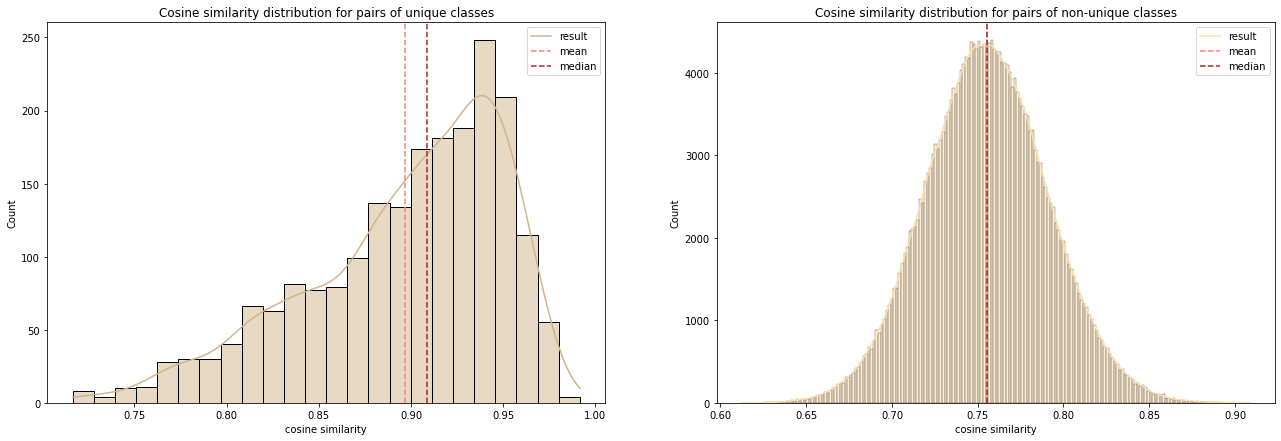

In [41]:
plt.figure(figsize=(22, 7))

plt.subplot(1, 2, 1)
sns.histplot(x=result_unique, color='tan', stat='count', kde = True)
plt.axvline(x=np.mean(result_unique), color = 'salmon', linestyle = '--')
plt.axvline(x=np.median(result_unique), color = 'brown', linestyle = '--')
plt.legend(['result', 'mean', 'median'])
plt.xlabel('cosine similarity')
plt.title('Cosine similarity distribution for pairs of unique classes')

plt.subplot(1, 2, 2)
sns.histplot(x=result_non_unique, color = 'navajowhite', stat='count', kde = True)
plt.axvline(x=np.mean(result_non_unique), color = 'salmon', linestyle = '--')
plt.axvline(x=np.median(result_non_unique), color = 'brown', linestyle = '--')

plt.legend(['result', 'mean', 'median'])
plt.xlabel('cosine similarity')
plt.title('Cosine similarity distribution for pairs of non-unique classes')

plt.show()

Как видно из графиков:
 - Для пар изображений одного класса распределение скошено вправо. Среднее значение выборки меньше медианы и моды. Мода распределения находится в районе 0,93  - этот показатель косинусного cходства чаще всего встречается в выборке.
 - Косинусные сходства для разных пар изображений имеют нормальное распределение. Среднее значение и медиана распределения находятся в интервале 0,75, что является приемлемым, т.к. нейросеть отличает, что на обоих фотографиях изображено лицо, а не например, лягушка (тогда значения сходства были бы ниже). Тем не менее сходство не достаточно велико, чтобы идентифицировать лицо на фото, как принадлежащее одному человеку.

## Task 2 (2 points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download using the code below:

In [42]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8978k  100 8978k    0     0  5744k      0  0:00:01  0:00:01 --:--:-- 27.6M
replace __MACOSX/._celebA_ir? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.


In [43]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors') 

In [49]:
def compute_embeddings(model, images_list, directory):
    '''
    compute embeddings from the trained model for list of images.
    params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
    output:
        list: list of model embeddings. Each embedding corresponds to images names from images_list
    '''
    list_emb = []
    modules = list(model.children())[:-1] 
    models_emb = nn.Sequential(*modules)
    
    transform  = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize(*normalize[0]),
])
    for file in images_list:
        image = Image.open(directory+file)
        image = transform(image)
        input_batch = image.unsqueeze(0) 
        with torch.no_grad():
            model.eval()
            emb = model(input_batch.to(device)).flatten().cpu().numpy()
            list_emb.append(emb)
    return list_emb  

In [ ]:
directory = './celebA_ir/celebA_distractors'
images_names = os.listdir(directory)[:5]
show_imgs(directory, images_names)

In [ ]:
directiry = './celebA_ir/celebA_query'
images_names = os.listdir(directiry)[:5]
show_imgs(directiry, images_names)

In [50]:
query_embeddings = compute_embeddings(model, query_img_names, './celebA_ir/celebA_query/')
distractors_embeddings = compute_embeddings(model, distractors_img_names, './celebA_ir/celebA_distractors/')

In [51]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
  '''
    cosine_list = []
    for class_ in query_dict.keys():
        index = [i for i in range(len(query_img_names)) for elem in query_dict[class_ ] if elem==query_img_names[i]]
        emb = np.array(query_embeddings)[index]
        for i, elem in enumerate(emb):
            for ii in range(i+1, len(emb)):
                cosine = np.dot(elem, emb[ii])/(norm(elem)*norm(emb[ii]))
                cosine_list.append(cosine)
    return cosine_list


In [52]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
  '''
    cosine_list, index_del = [], []
    for class_ in query_dict.keys():
        index_tr = [i for i in range(len(query_img_names)) for elem in query_dict[class_ ] if elem==query_img_names[i]]
        index_del.extend(index_tr)
        emb_tr = np.array(query_embeddings)[index_tr]
        index_fl = [i for i in range(len(query_img_names)) if i not in index_del]
        emb_fl = np.array(query_embeddings)[index_fl]
        for elem_tr in emb_tr:
            for elem_fl in emb_fl:
                cosine = np.dot(elem_tr, elem_fl)/(norm(elem_tr)*norm(elem_fl))
                cosine_list.append(cosine)
    return cosine_list

In [53]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
    cosine_list = []
    for elem_tr in query_embeddings:
        for elem_fl in distractors_embeddings:
            cosine = np.dot(elem_tr, elem_fl)/(norm(elem_tr)*norm(elem_fl))
            cosine_list.append(cosine)
    return cosine_list

In [54]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)


Check you code of functions which compute similarities:

In [55]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [56]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [57]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output: 
    float: threshold for given fpr 
    float: TPR at given FPR
  '''
    false_pairs = cosine_query_neg + cosine_query_distractors
    n = int(len(false_pairs)*fpr)
    threshold = sorted(false_pairs, reverse=True)[n]
    x = [x for x in cosine_query_pos if x > threshold]
    TPR = round(len(x)/len(cosine_query_pos),2)
    
    return threshold, TPR

Check yourself:

In [58]:
test_thr, test_tpr = [],[]
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [59]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [60]:
threshold_list = []
tpr_list, fpr_list = [],[0.5, 0.2, 0.1, 0.05]
for fpr in fpr_list:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    threshold_list.append(x)
    tpr_list.append(y)

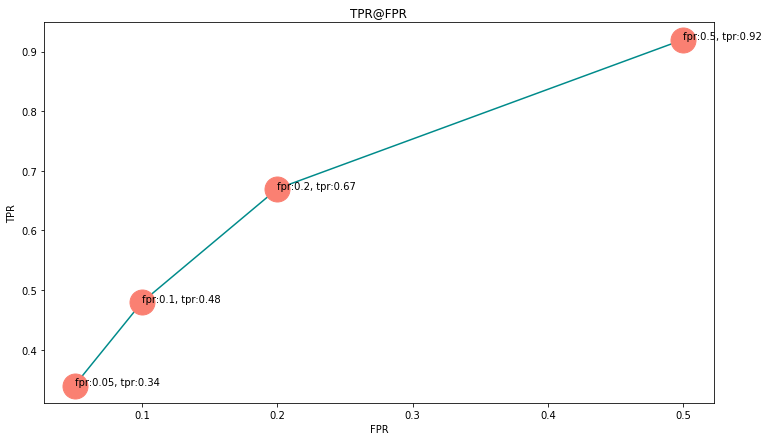

In [61]:
def show_TPR_FPR(fpr_list, tpr_list):
    plt.figure(figsize=(12, 7))
    coords = list(zip(fpr_list, tpr_list))
    plt.plot(fpr_list, tpr_list, color = 'darkcyan', marker='o', markersize=25, markerfacecolor='salmon', markeredgecolor='salmon')  
    for i, txt in enumerate(coords):
        plt.annotate (f'fpr:{coords[i][0]}, tpr:{coords[i][1]}', (coords[i][0], coords[i][1])) 

    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('TPR@FPR')
    plt.show()

show_TPR_FPR(fpr_list, tpr_list)

Наибольшое количество правильных положительных ответов мы получаем при значениях fpr равных 0.5

## Task 3 (4 points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (2 points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

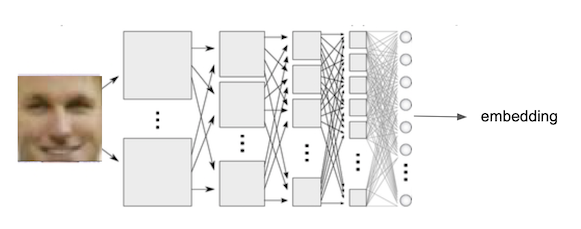

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embeddings from val and test sets calculate cosine similarities be 

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [62]:
batch_size = 128
train_loader_tl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader_tl = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader_tl = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [63]:
def pairwise_distances(embeddings, squared=False):

    dot_product = embeddings.mm(embeddings.t())

    square_sum = dot_product.diag()
    distances = square_sum.unsqueeze(1) - 2*dot_product + square_sum.unsqueeze(0)
    distances = distances.clamp(min=0)

    if not squared:
        epsilon=1e-16
        mask = torch.eq(distances, 0).float()
        distances = distances + mask*epsilon
        distances = torch.sqrt(distances)
        distances = distances*(1-mask)

    return distances

def get_valid_positive_mask(labels):
    """
    To be a valid positive pair (a,p),
        - a and p are different embeddings
        - a and p have the same label
    """
    indices_equal = torch.eye(labels.size(0), device=labels.device, dtype=torch.bool)
    indices_not_equal = ~indices_equal
    label_equal = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0))
    mask = indices_not_equal & label_equal
    return mask

def get_valid_negative_mask(labels):
    """
    To be a valid negative pair (a,n),
        - a and n are different embeddings
        - a and n have the different label
    """
    indices_equal = torch.eye(labels.size(0), device=labels.device, dtype=torch.bool)
    indices_not_equal = ~indices_equal
    label_not_equal = torch.ne(labels.unsqueeze(1), labels.unsqueeze(0))
    mask = indices_not_equal & label_not_equal
    return mask

def get_valid_triplets_mask(labels):
    """
    To be valid, a triplet (a,p,n) has to satisfy:
        - a,p,n are distinct embeddings
        - a and p have the same label, while a and n have different label
    """
    indices_equal = torch.eye(labels.size(0), device=labels.device, dtype=torch.bool)
    indices_not_equal = ~indices_equal
    i_ne_j = indices_not_equal.unsqueeze(2)
    i_ne_k = indices_not_equal.unsqueeze(1)
    j_ne_k = indices_not_equal.unsqueeze(0)
    distinct_indices = i_ne_j & i_ne_k & j_ne_k

    label_equal = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0))
    i_eq_j = label_equal.unsqueeze(2)
    i_eq_k = label_equal.unsqueeze(1)
    i_ne_k = ~i_eq_k
    valid_labels = i_eq_j & i_ne_k

    mask = distinct_indices & valid_labels
    return mask

In [64]:
def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """
    get triplet loss for all valid triplets and average over those triplets whose loss is positive.
    """

    distances = pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = distances.unsqueeze(2)
    anchor_negative_dist = distances.unsqueeze(1)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    mask = get_valid_triplets_mask(labels)

    triplet_loss = triplet_loss * mask.float()
    triplet_loss.clamp_(min=0)

    epsilon = 1e-16
    num_positive_triplets = (triplet_loss > 0).float().sum()
    num_valid_triplets = mask.float().sum()

    triplet_loss = triplet_loss.sum()/(num_positive_triplets + epsilon)

    return triplet_loss

In [65]:
def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """
    - compute distance matrix
    - for each anchor a0, find the (a0,p0) pair with greatest distance s.t. a0 and p0 have the same label
    - for each anchor a0, find the (a0,n0) pair with smallest distance s.t. a0 and n0 have different label
    - compute triplet loss for each triplet (a0, p0, n0), average them
    """
    distances = pairwise_distances(embeddings, squared=squared)

    mask_positive = get_valid_positive_mask(labels)
    hardest_positive_dist = (distances*mask_positive.float()).max(dim=1)[0]

    mask_negative = get_valid_negative_mask(labels)
    max_negative_dist = distances.max(dim=1,keepdim=True)[0]
    distances = distances + max_negative_dist*(~mask_negative).float()
    hardest_negative_dist = distances.min(dim=1)[0]

    triplet_loss = (hardest_positive_dist - hardest_negative_dist + margin).clamp(min=0)
    triplet_loss = triplet_loss.mean()

    return triplet_loss

In [66]:
loaders = {'train': train_loader_tl, 'valid': val_loader_tl}
functions = {'batch_all_triplet_loss': batch_all_triplet_loss, 'batch_hard_triplet_loss':batch_hard_triplet_loss}

In [67]:
def TPR_FPR(model):
    
    query_embeddings = compute_embeddings(model, query_img_names, './celebA_ir/celebA_query/')
    distractors_embeddings = compute_embeddings(model, distractors_img_names, './celebA_ir/celebA_distractors/')
    cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
    cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)
    
    threshold_list = []
    tpr_list, fpr_list  = [], [0.5, 0.2, 0.1, 0.05]
    for fpr in fpr_list:
        x, y = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
        threshold_list.append(x)
        tpr_list.append(y)
    return fpr_list, tpr_list

In [68]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(True) 

modules = list(resnet.children())[:-1] 
model_TL = nn.Sequential(*modules).to(device)

optimizer = AdamW(model_TL.parameters(), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=30)
knn = KNeighborsClassifier(metric='cosine')

In [69]:
def train2(model, optimizer, scheduler, epochs, loaders, loss_fn, margin, file_name):
    best_score, valid_loss = 0, 0
    
    for epoch in range(epochs):
        labels_list, predictions_list, emb_list = [],[],[]
        result['epoch'].append(epoch+1)
    
        for mode, dataloader in tqdm(loaders.items()):
            loss_result = []
      
            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                if mode =='train':
                    model.train()
                    optimizer.zero_grad() 
                    emb = torch.flatten(model(X_batch), start_dim = 1)

                else: 
                    model.eval()  
                    with torch.no_grad(): 
                        emb = torch.flatten(model(X_batch), start_dim = 1)
        
                loss = functions[loss_fn](Y_batch, emb, margin)
                loss_result.append(loss.cpu().detach().numpy())
                emb_list.extend(emb.cpu().detach().numpy())
                labels_list.extend(Y_batch.cpu().numpy())

                if mode =='train':
                    loss.backward()
                    optimizer.step()
            
            features, target = np.array(emb_list), np.array(labels_list)
            if mode =='train':
                knn.fit(features, target)
                predictions = knn.predict(features)
                
            else:
                predictions = knn.predict(features)
            
            accuracy = accuracy_score(target, predictions)
            result[str(mode)+'_loss'].append(np.mean(loss_result)) 
            result[str(mode)+'_accuracy'].append(accuracy) 

            if mode =='valid':
                if accuracy > best_score:
                    best_score = accuracy
                    torch.save(model.state_dict(), f'saved_weights_{file_name}.pt') 
                valid_loss = np.mean(loss_result)
            
            lr = optimizer.param_groups[0]['lr'] 
            scheduler.step(valid_loss)

        
        clear_output(wait=True)
        print(f'epoch training: {epoch+1}, lr optimizer: {lr}, loss value validate:{valid_loss:10.4f}, accuracy validate:{accuracy:10.4f}')
        print()

        show_result(result, best_score)  

In [70]:
def evaluate2(model, dataloader, loss_fn, margin):
    
    loss_result = []
    labels_list, predictions_list, emb_list = [],[],[]

    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
            model.eval()
            emb = torch.flatten(model(X_batch), start_dim = 1)
            
        loss = functions[loss_fn](Y_batch, emb, margin)
        loss_result.append(loss.cpu().detach().numpy())
    
        emb_list.extend(emb.cpu().detach().numpy())
        labels_list.extend(Y_batch.cpu().numpy())
            
    features, target = np.array(emb_list), np.array(labels_list)
    predictions = knn.predict(features)
    accuracy = accuracy_score(target, predictions)    
    
    return accuracy, np.mean(loss_result), features, target

epoch training: 30, lr optimizer: 1e-05, loss value validate:    0.5445, accuracy validate:    0.8350



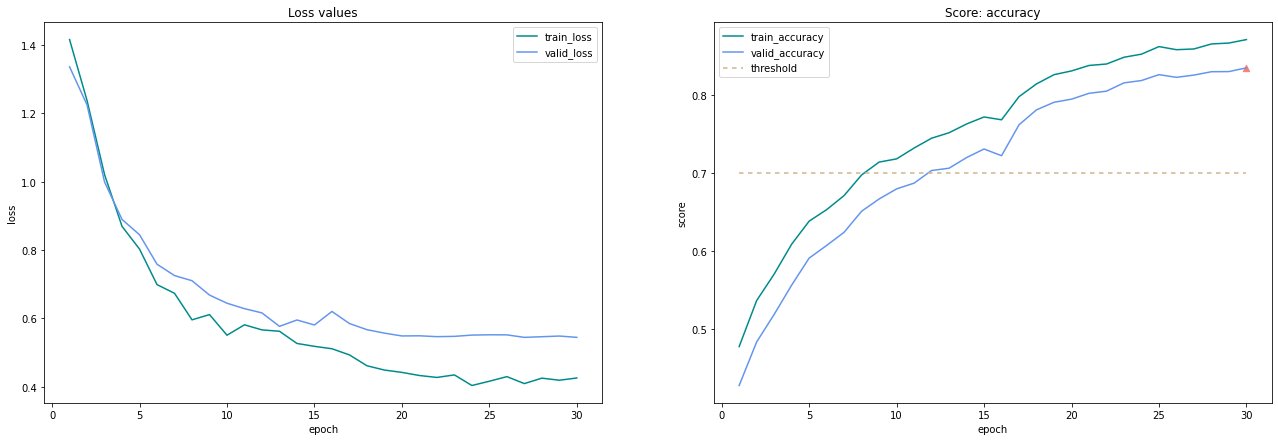

In [71]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_accuracy':[],'valid_accuracy':[]
}
epochs = 30
train2(model_TL, optimizer, scheduler, epochs, loaders, 'batch_all_triplet_loss', 0.4, 'resnet_50_tl_batch_all')

In [72]:
test_accuracy_tl_batch_all, test_loss, features, labels = evaluate2(model_TL, test_loader_tl, 'batch_all_triplet_loss', 0.4)
print(f'test loss:{test_loss:10.4f}, test accuracy:{test_accuracy_tl_batch_all:10.4f}')
df_tl_batch_all = pd.DataFrame(result)[['epoch', 'valid_accuracy']]

test loss:    0.5503, test accuracy:    0.6916


In [73]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(True) 

modules = list(resnet.children())[:-1] 
model_TL_bh = nn.Sequential(*modules).to(device)

optimizer = AdamW(model_TL_bh.parameters(), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=24)
knn = KNeighborsClassifier(metric='cosine')

epoch training: 30, lr optimizer: 1.0000000000000002e-06, loss value validate:    1.1826, accuracy validate:    0.8867



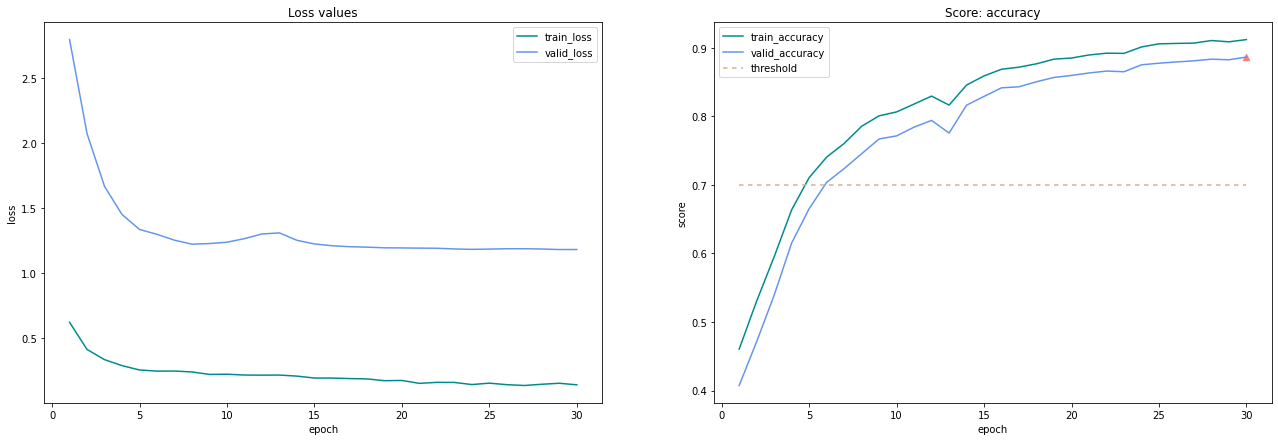

In [74]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_accuracy':[],'valid_accuracy':[]
}
epochs = 30
train2(model_TL_bh, optimizer, scheduler, epochs, loaders, 'batch_hard_triplet_loss', 1,  'resnet_50_tl_batch_hard')

In [75]:
test_accuracy_tl_batch_hard, test_loss, features, labels = evaluate2(model_TL_bh, test_loader_tl, 'batch_hard_triplet_loss', 1)
print(f'test loss:{test_loss:10.4f}, test accuracy:{test_accuracy_tl_batch_hard:10.4f}')
df_tl_batch_hard = pd.DataFrame(result)[['epoch', 'valid_accuracy']]

test loss:    1.1260, test accuracy:    0.7627


В обоих вариантах (batch_all_triplet_loss и batch_hard_triplet_loss) мы получили примерно одинаковую точность (около 70-75%) за 30 эпох. Показатель margin варьировался в зависимости от используемой функции потерь. 

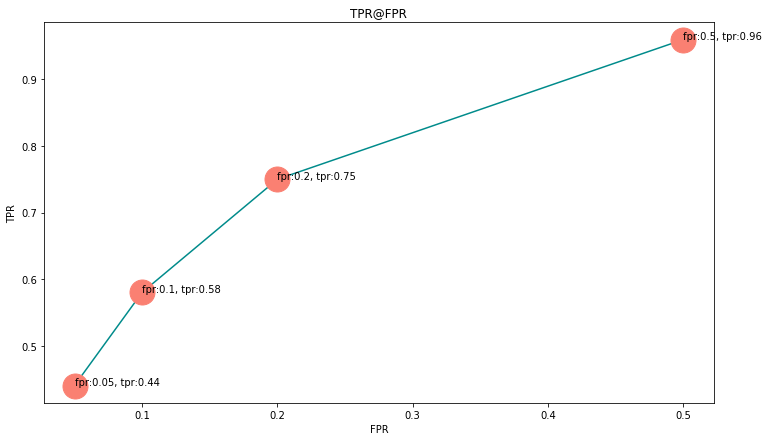

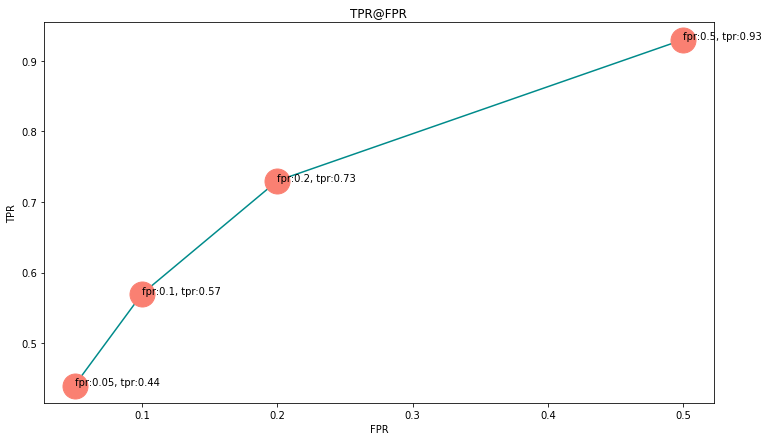

In [76]:
fpr_tl_ba, tpr_tl_ba = TPR_FPR(model_TL)
fpr_tl_bh, tpr_tl_bh = TPR_FPR(model_TL_bh)

show_TPR_FPR(fpr_tl_ba, tpr_tl_ba)
show_TPR_FPR(fpr_tl_bh, tpr_tl_bh)

Использование функции потерь triplet loss дает нам большую площадь под кривой. Это означает, что даже при минимальном значении порога FPR мы получим большее количество правильных положительных ответов, чем при использовании в качестве лосса кросс-энтропии.

### ArcFace Loss (Additive Angular Margin Loss) (2 points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

**To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**

In [81]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, scale=5, margin_arc=0.5):
        super().__init__()
        self.scale = scale
        self.sin_m = torch.sin(torch.tensor(margin_arc))
        self.cos_m = torch.cos(torch.tensor(margin_arc))
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, label=None):
        w_L2 = torch.linalg.norm(self.fc.weight.detach(), dim=1, keepdim=True).T
        x_L2 = torch.linalg.norm(x, dim=1, keepdim=True)
        cos = self.fc(x)/(x_L2*w_L2)

        if label is not None:
            sin_m, cos_m = self.sin_m, self.cos_m
            one_hot = F.one_hot(label, num_classes=self.out_features)
            sin = (1 - cos ** 2) ** 0.5
            angle_sum = cos * cos_m - sin * sin_m
            cos = angle_sum * one_hot + cos * (1 - one_hot)
            cos = cos * self.scale
                        
        return cos

In [82]:
class ModelNet(nn.Module):
    def __init__(self, channel_size, out_features, backbone, margin):
        super(ModelNet, self).__init__()
        self.backbone = backbone
        self.margin = ArcFace(in_features=channel_size, out_features = out_features, margin_arc = margin)
        
    def forward(self, x, labels=None):
        x = self.backbone(x)
        if labels is not None:
            return self.margin(x, labels)
        return x

In [83]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(True) 

resnet.fc = nn.Sequential(
                    nn.Linear(resnet.fc.in_features, n_classes)
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [84]:
model_arc = ModelNet(n_classes, n_classes, resnet, 0.05).to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = AdamW(model_arc.parameters(), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20)
loaders = {'train': train_loader, 'valid': val_loader}

epoch training: 20, lr optimizer: 1e-05, loss value validate:    3.2456, accuracy validate:    0.7588



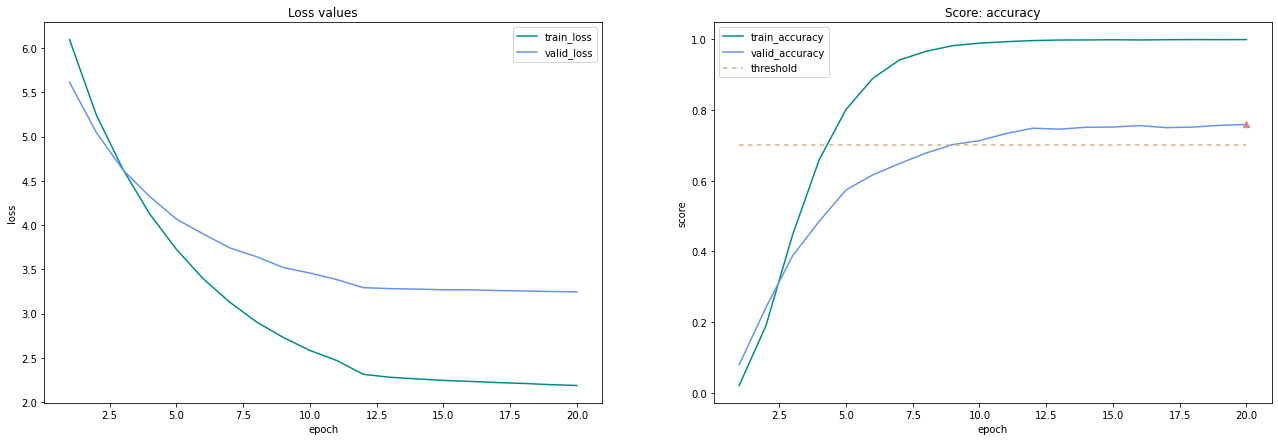

In [85]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_accuracy':[],'valid_accuracy':[]
}
epochs = 20
train(model_arc, optimizer, scheduler, criterion, epochs, loaders,'resnet18_arc', 'yes')

In [86]:
test_accuracy_arc, test_loss = evaluate(model_arc, test_loader, criterion, 'yes')
print(f'test loss:{test_loss:10.4f}, test accuracy:{test_accuracy_arc:10.4f}')

labels_list_arc, emb_list_arc = get_embeddings(model_arc, test_loader, 'yes')
df_arc = pd.DataFrame(result)[['epoch', 'valid_accuracy']]

test loss:    3.2404, test accuracy:    0.7546


На 20  эпохах мы получили точность в 76%. Функция потерь в 6 раз выше, чем на дефолтной моделе.

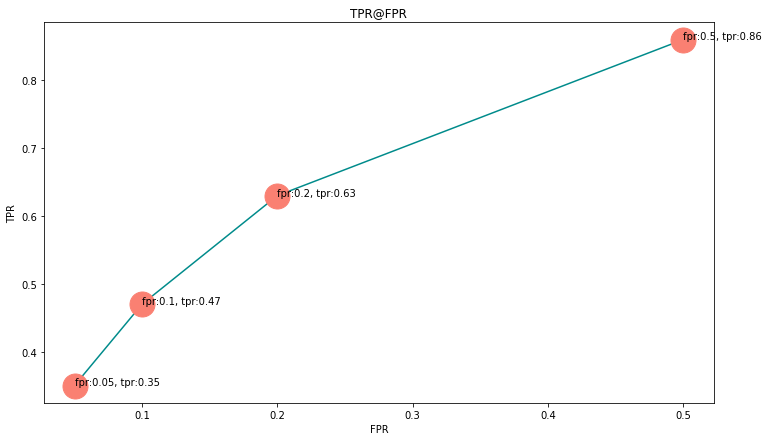

In [87]:
fpr_arc, tpr_arc = TPR_FPR(model_arc)
show_TPR_FPR(fpr_arc, tpr_arc)

Дополнительно посмотрим, как распределены в пространстве классы для дефолтной модели и для модели с использованием ArcFace. Возьмем для примера 30 рандомных классов.

In [88]:
random_character = np.random.randint(0, 500, 30)
emb_elem_sm, labels_elem_sm, emb_elem_arc, labels_elem_arc = [],[],[],[]
for k in random_character:
    index = np.where(labels_list_sm==k)
    emb_elem_sm.extend(emb_list_sm[index])
    labels_elem_sm.extend(labels_list_sm[index])
    index = np.where(labels_list_arc==k)
    emb_elem_arc.extend(emb_list_arc[index])
    labels_elem_arc.extend(labels_list_arc[index])
  

In [89]:
emb_sm = TSNE(n_components=2).fit_transform(emb_elem_sm)
emb_arc = TSNE(n_components=2).fit_transform(emb_elem_arc)

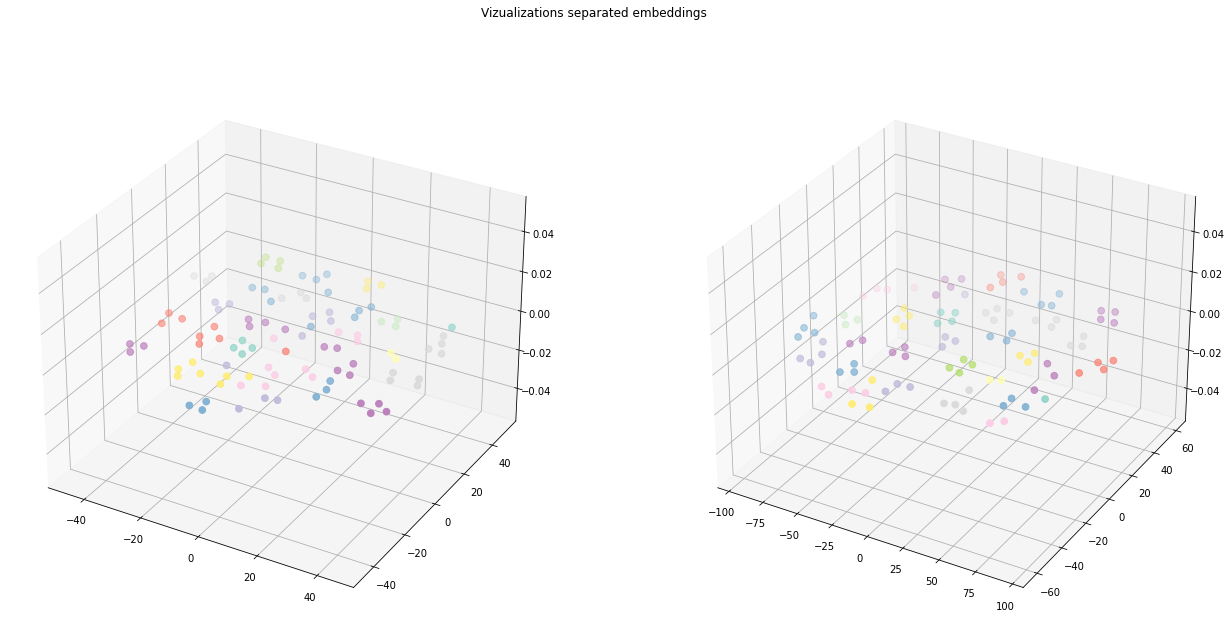

In [98]:
_,(ax1,ax2) = plt.subplots(1,2, figsize=(22,10), subplot_kw={'projection':'3d'})
ax1.scatter(emb_sm[:, 0], emb_sm[:, 1], c=labels_elem_sm, cmap='Set3', marker='o', s = 45)
ax2.scatter(emb_arc[:, 0], emb_arc[:, 1], c=labels_elem_arc, cmap='Set3', marker='o', s = 45)
plt.suptitle('Vizualizations separated embeddings')
plt.show()

На первом графике ембеддинги разделены грубо, существует неопределенность, где могут быть размещены границы решений. Это означает, что лица, которые выглядят одинаково, будет трудно различить.

Эмбеддинги, полученные с помощью ArcFace (2 график) не имеет этого недостатка, и результат кажется намного лучше. Все точки расположены более "скучены", и между тождествами имеется явный разрыв. Внутриклассовая компактность и межклассовая разделимость выполняется.

## Bonus task (0.5 points): Finding trash photos 

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. And in TripletLoss also we normalize embeddings before passing them to the loss. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is. 



**Task**: get the embeddings of photos in a test set / query set / distractors set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may give you additional points (5% of total points) to cover points lost.**

In [135]:
n_images = 2000

modules = list(model.children())[:-1] 
models_emb = nn.Sequential(*modules)

embedings = {
    'train_images':[],
    'train_norm':[],
    'test_images':[],
    'test_norm': []
}

train_loader_one_image = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader_one_image = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

loaders = {'train':train_loader_one_image, 'test': test_loader_one_image}

По предлагаемому описанию к задаче не удалось получить треш-фото. Но в процессе экспериментов, выяснилось, что деление единицы на нормализованный эмбеддинг позволяет отловить не очень качественно сделанные фотографии

In [136]:
for mode, loader in loaders.items():
    len_cumulative = 0
    for X_batch, Y_batch in loader:
        if len_cumulative<n_images:
            with torch.no_grad():
                models_emb.eval()
                emb = models_emb(X_batch.to(device)).flatten().cpu().numpy()
            embedings[str(mode)+'_images'].append(X_batch)
            embedings[str(mode)+'_norm'].append(1/norm(emb))
     
        len_cumulative+=len(X_batch)

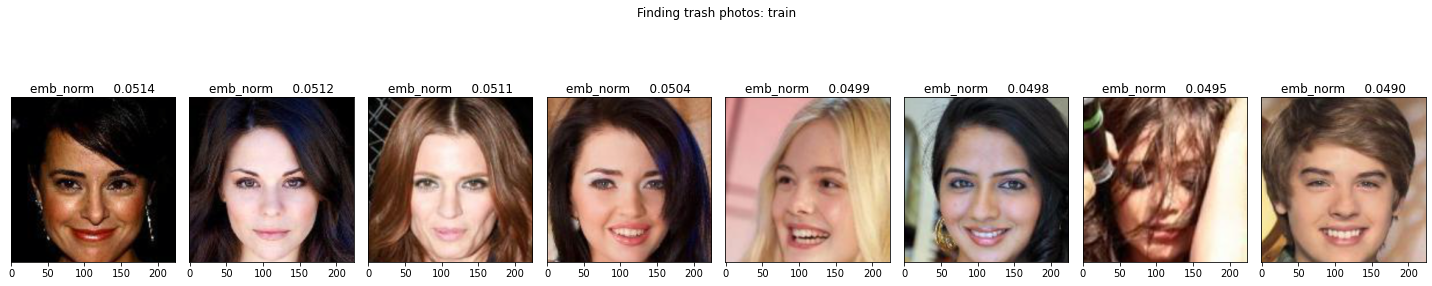

In [137]:
index = np.argsort(embedings['train_norm'])[::-1]
plt.figure(figsize=(20, 5))

for i in range(8):
    plt.subplot(1, 8, i+1)
    value_norm = embedings['train_norm'][index[i]]
    imshow(embedings['train_images'][index[i]][0], normalize[0], title=f'emb_norm {value_norm:10.4f}')
    plt.yticks([])
    plt.tight_layout()
plt.suptitle('Finding trash photos: train')
plt.show()

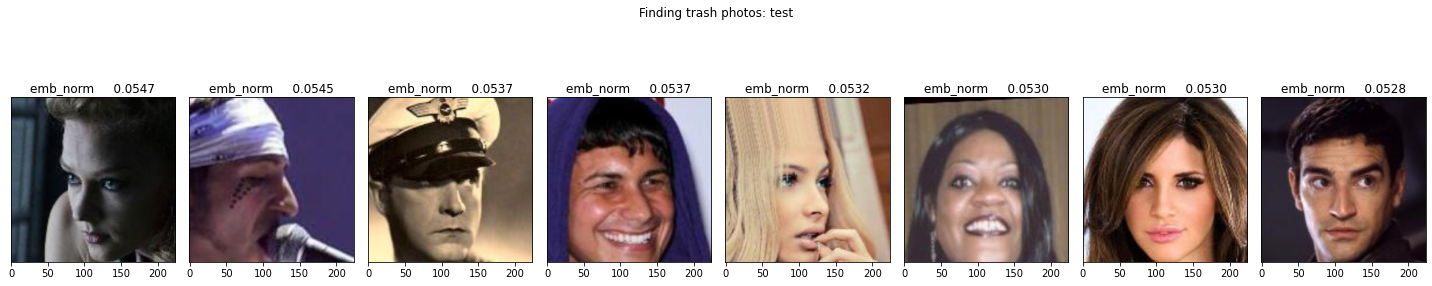

In [138]:
index = np.argsort(embedings['test_norm'])[::-1]
plt.figure(figsize=(20, 5))

for i in range(8):
    plt.subplot(1, 8, i+1)
    value_norm = embedings['test_norm'][index[i]]
    imshow(embedings['test_images'][index[i]][0], normalize[0], title=f'emb_norm {value_norm:10.4f}')
    plt.yticks([])
    plt.tight_layout()
plt.suptitle('Finding trash photos: test')
plt.show()

## Выводы

1. Задачей данного проекта являлось научиться использовать 3 часть пайплана по распознаванию лиц, а также попробовать реализовать несколько loss-функций и метрики Identificaton rate.
2. Для этих целей было обучено 4 модели:
 - предобученная Resnet50 c двумя линейными слоями (примем ее как дефолтную)
 - предобученная Resnet50 с лосс-функцией triplet loss batch all
 - предобученная Resnet50 с лосс-функцией triplet loss batch hard
 - предобученная Resnet18 c использованием функции потерь Arcface
В качестве оптимизатора для всех моделей был использован AdamW с начальной скоростью обучения 0,001. В качестве шедулера использовался ReduceLROnPlateau.
3. В качестве метрик оценки качества использовались accuracy и Identificaton rate.
4. На графике 'Validation accuracy for all models' показана динамика обучения представленных моделей. Как видно, наибольшей точности на валидации удалось добиться используя дефолтную модель. Функция потерь также принимала самые минимальные значения (в сравнении с Arcface). Следует отметить, что при использовании в качестве функции потерь triplet loss точность прогноза (на валидации) растет с увеличением количества эпох в обучении, при этом после 20 эпохи loss выходит на плато. Возможно это поддается корректировке с помощью более тонкой настройки ReduceLROnPlateau.
5. На графике 'Result accuracy test_loader' представлены результаты тестирования различных моделей. Как видно из данных, точность прогноза выше у дефолтной модели. Следует отметить, что при кластеризации полученные с помощью ArcFace эмбеддингов, точки расположены ближе к друг другу внутри класса, и между тождествами имеется явный разрыв. Т.е. потенциально эта модель может быть более эффективна, просто нужно подобрать правильные параметры.
6. График 'TPR@FPR for all models' показывает кривую TPR@FPR для различных моделей. Использование функции потерь triplet loss дает нам большую площадь под кривой. Это означает, что даже при минимальном значении порога FPR мы получим большее количество правильных положительных ответов, чем при использовании в качестве лосса кросс-энтропии.

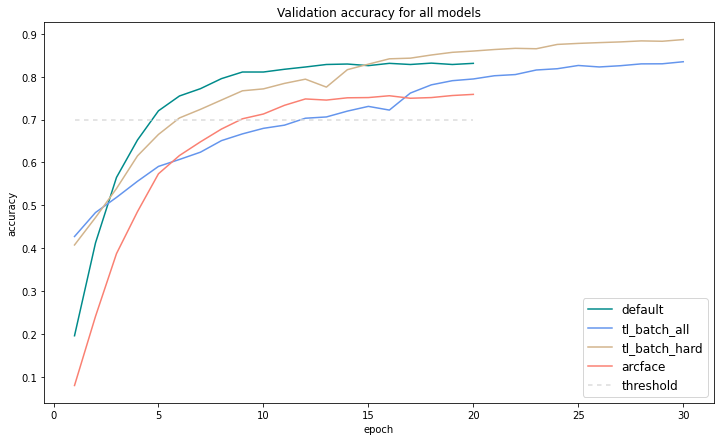

In [95]:
plt.figure(figsize=(12, 7))
plt.title('Validation accuracy for all models')
plt.xlabel('epoch')
plt.ylabel('accuracy')
sns.lineplot(x=df_default['epoch'], y=df_default['valid_accuracy'], color = 'darkcyan')
sns.lineplot(x=df_tl_batch_all['epoch'], y=df_tl_batch_all['valid_accuracy'], color = 'cornflowerblue')
sns.lineplot(x=df_tl_batch_hard['epoch'], y=df_tl_batch_hard['valid_accuracy'], color = 'tan')
sns.lineplot(x=df_arc['epoch'], y=df_arc['valid_accuracy'], color = 'salmon')
sns.lineplot(x=df_default['epoch'], y=0.7, style=True, dashes=[(3,3)], color = 'gainsboro')

plt.legend(['default', 'tl_batch_all', 'tl_batch_hard', 'arcface', 'threshold'], loc = 'lower right',fontsize = 'large')
plt.show()

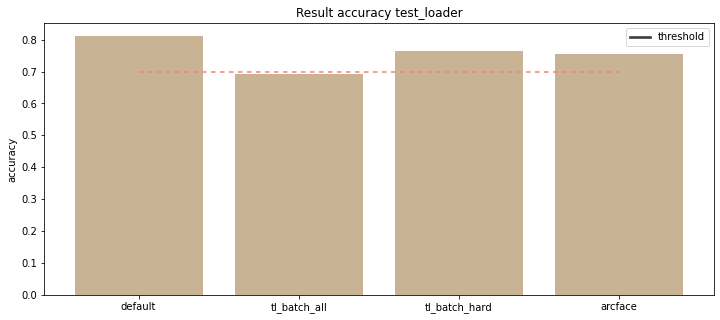

In [96]:
labels = ['default', 'tl_batch_all', 'tl_batch_hard', 'arcface']
values = [test_accuracy, test_accuracy_tl_batch_all, test_accuracy_tl_batch_hard, test_accuracy_arc]

plt.figure(figsize=(12, 5))
sns.barplot(x=labels, y=values, color = 'tan')
sns.lineplot(x=labels, y=0.7, style=True, dashes=[(3,3)], color = 'salmon')
plt.ylabel('accuracy')
plt.title('Result accuracy test_loader')
plt.legend(['threshold'])
plt.show()

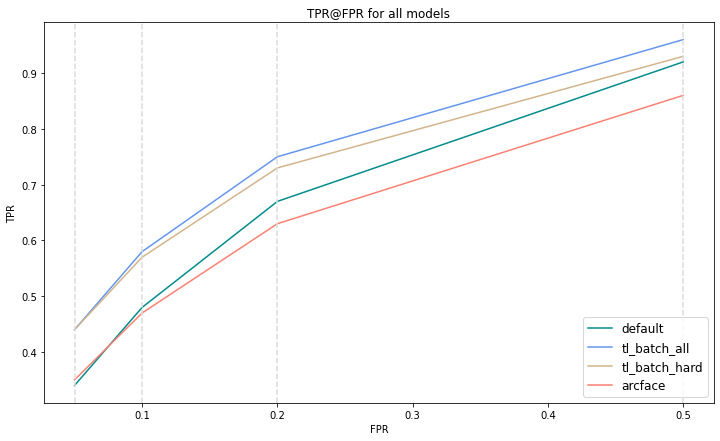

In [97]:
plt.figure(figsize=(12, 7))
plt.title('TPR@FPR for all models')
plt.xlabel('FPR')
plt.ylabel('TPR')
sns.lineplot(x=fpr_list, y=tpr_list, color = 'darkcyan')
sns.lineplot(x=fpr_list, y=tpr_tl_ba, color = 'cornflowerblue')
sns.lineplot(x=fpr_list, y=tpr_tl_bh, color = 'tan')
sns.lineplot(x=fpr_list, y=tpr_arc, color = 'salmon')
plt.axvline(x=0.05, color = 'gainsboro', linestyle = '--')
plt.axvline(x=0.1, color = 'gainsboro', linestyle = '--')
plt.axvline(x=0.2, color = 'gainsboro', linestyle = '--')
plt.axvline(x=0.5, color = 'gainsboro', linestyle = '--')
plt.legend(['default', 'tl_batch_all', 'tl_batch_hard', 'arcface'], loc = 'lower right',fontsize = 'large')
plt.show()

## What's next

What else can you do with this homework:
1. Try to train the network on faces which are aligned differently (or not aligned at all). The dataset [can be downloaded here](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ)
2. Try to mix different losses while training. This often helps.
3. Try other losses from [this](https://arxiv.org/pdf/1901.05903.pdf) paper
4. Train bigger model on bigger dataset, as whole celebA, add [LFW](http://vis-www.cs.umass.edu/lfw/) and other
5. Explore embeddings spaces you get out of different models. How well are embeddings clasterized? Are they evenly spreaded on the sphere? How could you suggest to make it better?